# Self-Driving Car Engineer Nanodegree


## Project: **Advanced Lane Lines** 
***

---

---

## Import Packages

In [11]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob

## Calibrate camera and undistort

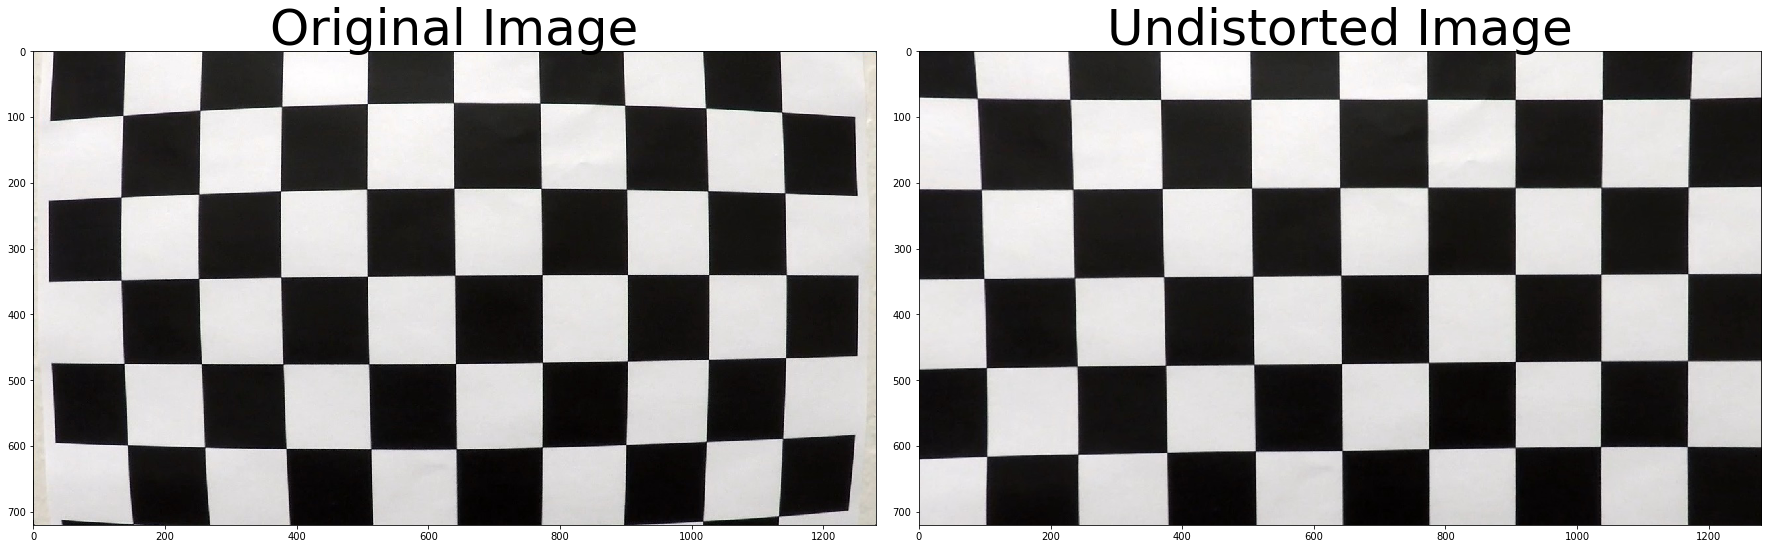

In [12]:
# Read in an image
images = glob.glob('C:/Users/Raul/Documents/CarND-Advanced-Lane-Lines/camera_cal/calibration*.jpg')

# prepare object points
nx = 9
ny = 6

# Arrays to store object points and image points from all the images
objpoints = [] # 3D points in real world space
imgpoints = [] # 2D points in image plane

# Prepare object points (for example, (3,1,0))
objp= np.zeros((nx*ny,3), np.float32)
objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2)

for fname in images:

    # Read in each image
    image = mpimg.imread(fname)

    # Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)

    # If found, draw corners
    if ret == True:
        imgpoints.append(corners)
        objpoints.append(objp)
        
        # Draw and display the corners
        #cv2.drawChessboardCorners(image, (nx, ny), corners, ret)
        #plt.imshow(image)
        #plt.show()

image_test_calibration = mpimg.imread('C:/Users/Raul/Documents/CarND-Advanced-Lane-Lines/test_images/test_image_calibration.jpg')

ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, image_test_calibration.shape[1::-1], None, None)
undistorted = cv2.undistort(image_test_calibration, mtx, dist, None, mtx)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(image_test_calibration)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(undistorted)
ax2.set_title('Undistorted Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.show()

## Distortion correction test image

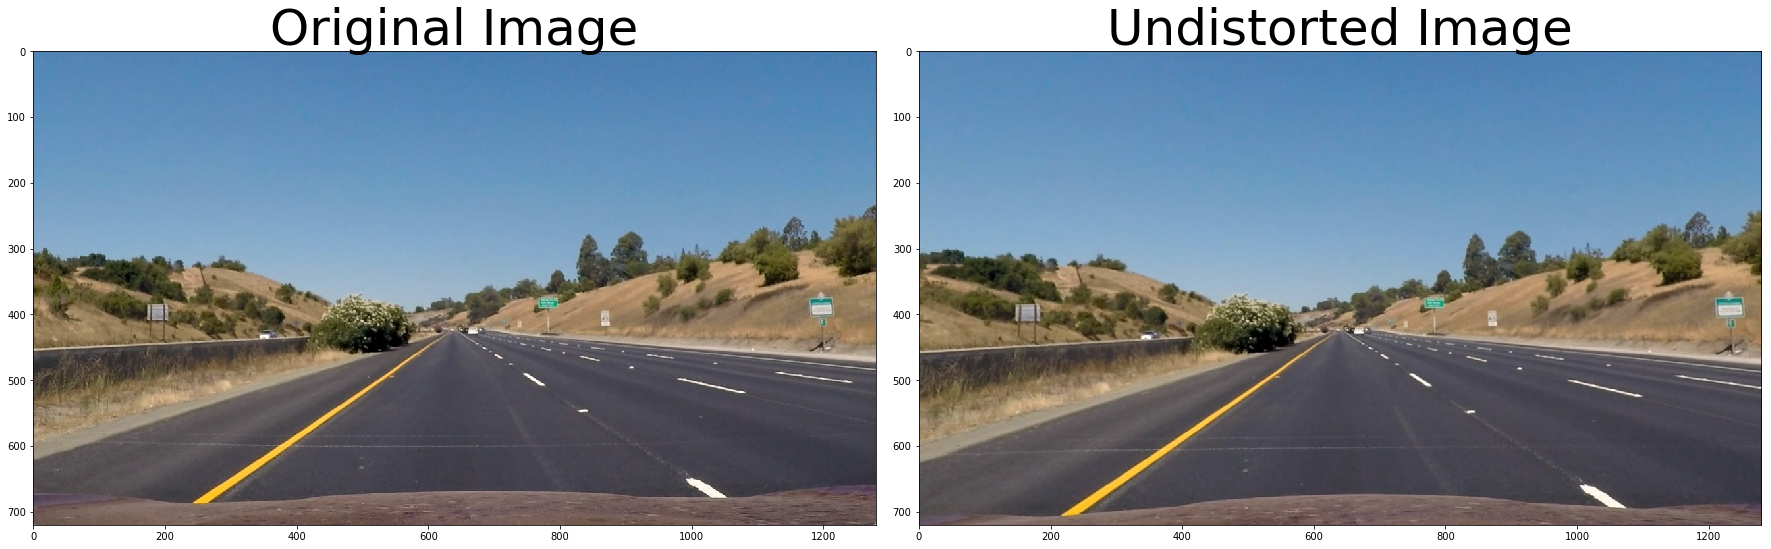

In [13]:
image_test = mpimg.imread('C:/Users/Raul/Documents/CarND-Advanced-Lane-Lines/test_images/straight_lines1.jpg')

undistorted_test = cv2.undistort(image_test, mtx, dist, None, mtx)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(image_test)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(undistorted_test)
ax2.set_title('Undistorted Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.show()

## Color and gradient threshold

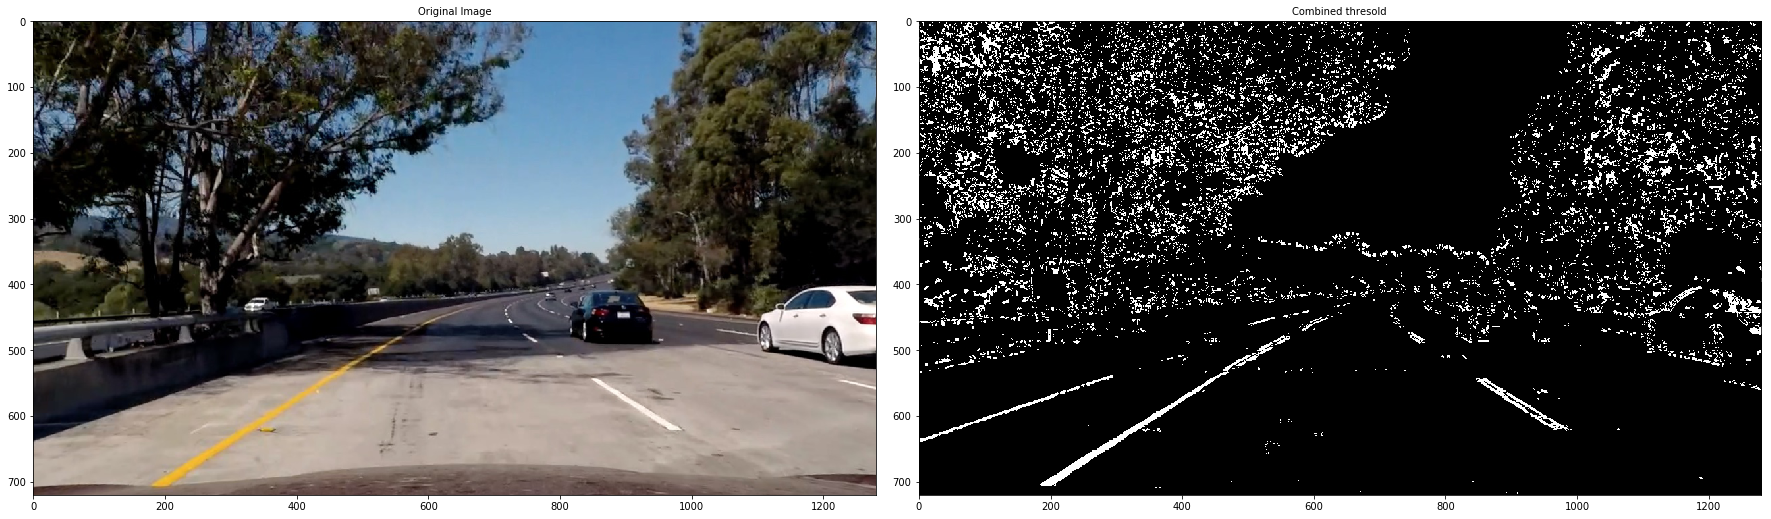

In [14]:
image = mpimg.imread('C:/Users/Raul/Documents/CarND-Advanced-Lane-Lines/test_images/test5.jpg')

def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    # Calculate directional gradient
    # Apply threshold
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # 2) Take the derivative in x or y given orient = 'x' or 'y'
    sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    # 3) Take the absolute value of the derivative or gradient
    abs_sobel = np.absolute(sobel)
    # 4) Scale to 8-bit (0 - 255) then convert to type = np.uint8
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # 5) Create a mask of 1's where the scaled gradient magnitude 
            # is > thresh_min and < thresh_max
    sbinary = np.zeros_like(scaled_sobel)
    sbinary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1

    return sbinary

def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Calculate gradient direction
    # Apply threshold
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # 3) Take the absolute value of the x and y gradients
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)
    # 4) Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient 
    dir_grad = np.arctan2(abs_sobely, abs_sobelx)
    # 5) Create a binary mask where direction thresholds are met
    sxybinary = np.zeros_like(dir_grad)
    sxybinary[(dir_grad > thresh[0]) & (dir_grad < thresh[1])] = 1
    # 6) Return this mask as your binary_output image
    return sxybinary

def h_threshold(img, h_thresh=(15,100)):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    h_channel = hls[:,:,0]
	# Threshold color channel
    h_binary = np.zeros_like(h_channel)
    h_binary[(h_channel >= h_thresh[0]) & (h_channel <= h_thresh[1])] = 1
    return h_binary
	
def s_threshold(img, s_thresh=(170,255)):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    s_channel = hls[:,:,2]
	# Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    return s_binary

# Choose a Sobel kernel size
ksize = 9 # Choose a larger odd number to smooth gradient measurements

undist = cv2.undistort(image, mtx, dist, None, mtx)

# Apply each of the thresholding functions
grady = abs_sobel_thresh(undist, orient='y', sobel_kernel=ksize, thresh=(20, 100))
dir_binary = dir_threshold(undist, sobel_kernel=ksize, thresh=(0.7, 1.4))
h_binary = h_threshold(undist, h_thresh=(15,100))
s_binary = s_threshold(undist, s_thresh=(170,255))

combined_gradient = np.zeros_like(dir_binary)
combined_gradient[(grady == 1) & (dir_binary == 1)] = 1

combined_color = np.zeros_like(dir_binary)
combined_color[(h_binary == 1) & (s_binary == 1)] = 1

combined = np.zeros_like(combined_gradient)
combined[(combined_gradient == 1) | (combined_color == 1)] = 1

# Plot the result
f, (ax1, ax6) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(undist)
ax1.set_title('Original Image', fontsize=10)
"""
ax2.imshow(gradx, cmap='gray')
ax2.set_title('Directional gradient X', fontsize=10)
ax3.imshow(grady, cmap='gray')
ax3.set_title('Directional gradient Y', fontsize=10)
ax4.imshow(mag_binary, cmap='gray')
ax4.set_title('Gradient magnitude', fontsize=10)
ax5.imshow(dir_binary, cmap='gray')
ax5.set_title('Thresholded Grad. Dir.', fontsize=10)
"""
ax6.imshow(combined, cmap='gray')
ax6.set_title('Combined thresold', fontsize=10)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.show()

## Perspective transform


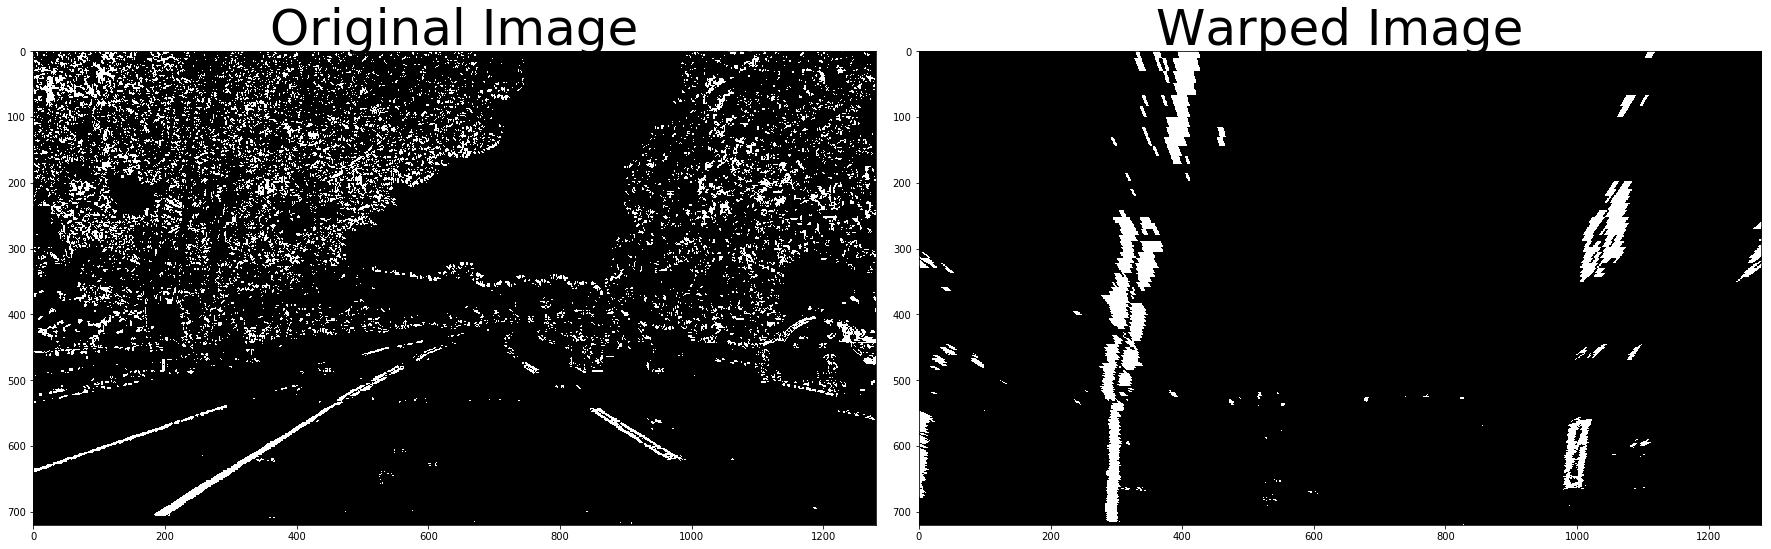

In [15]:
def warper(img, src, dst):

    # Compute and apply perpective transform
    img_size = (img.shape[1], img.shape[0])
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_NEAREST)  # keep same size as input image

    return warped, Minv

src = np.float32([[206,720], [1097,720], [580,460], [700,460]])
dst = np.float32([[320,720], [960,720], [320,0], [960,0]])

binary_warped, Minv = warper(combined, src, dst)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(combined, cmap='gray')
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(binary_warped, cmap='gray')
ax2.set_title('Warped Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.show()

## Finding lines

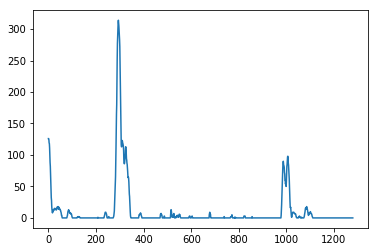

In [16]:
histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
plt.plot(histogram)
plt.show()

## Sliding window and fit polynomial

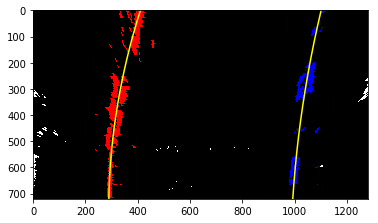

In [17]:
def slid_window_fit_poly(binary_warped, histogram):

    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))

    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
        (0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
        (0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Visualization

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [1, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 1]

    plt.imshow(out_img)
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    plt.xlim(0, 1280)
    plt.ylim(720, 0)
    plt.show()
    
    return out_img, ploty, left_fit, right_fit, left_fitx, right_fitx, leftx, lefty, rightx, righty

out_img, ploty, left_fit, right_fit, left_fitx, right_fitx, leftx, lefty, rightx, righty = \
slid_window_fit_poly(binary_warped, histogram)

## New binary_warped

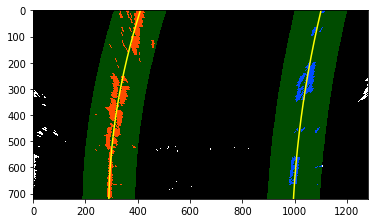

(array([[[ 0.,  0.,  0.],
         [ 0.,  0.,  0.],
         [ 0.,  0.,  0.],
         ..., 
         [ 0.,  0.,  0.],
         [ 0.,  0.,  0.],
         [ 0.,  0.,  0.]],
 
        [[ 0.,  0.,  0.],
         [ 0.,  0.,  0.],
         [ 0.,  0.,  0.],
         ..., 
         [ 0.,  0.,  0.],
         [ 0.,  0.,  0.],
         [ 0.,  0.,  0.]],
 
        [[ 0.,  0.,  0.],
         [ 0.,  0.,  0.],
         [ 0.,  0.,  0.],
         ..., 
         [ 0.,  0.,  0.],
         [ 0.,  0.,  0.],
         [ 0.,  0.,  0.]],
 
        ..., 
        [[ 0.,  0.,  0.],
         [ 0.,  0.,  0.],
         [ 0.,  0.,  0.],
         ..., 
         [ 0.,  0.,  0.],
         [ 0.,  0.,  0.],
         [ 0.,  0.,  0.]],
 
        [[ 0.,  0.,  0.],
         [ 0.,  0.,  0.],
         [ 0.,  0.,  0.],
         ..., 
         [ 0.,  0.,  0.],
         [ 0.,  0.,  0.],
         [ 0.,  0.,  0.]],
 
        [[ 0.,  0.,  0.],
         [ 0.,  0.,  0.],
         [ 0.,  0.,  0.],
         ..., 
         [ 0.,  0.,  0.

In [18]:
image = mpimg.imread('C:/Users/Raul/Documents/CarND-Advanced-Lane-Lines/test_images/test5.jpg')
undist = cv2.undistort(image, mtx, dist, None, mtx)

# Apply each of the thresholding functions
grady = abs_sobel_thresh(undist, orient='y', sobel_kernel=ksize, thresh=(20, 100))
dir_binary = dir_threshold(undist, sobel_kernel=ksize, thresh=(0.7, 1.4))
h_binary = h_threshold(undist, h_thresh=(15,100))
s_binary = s_threshold(undist, s_thresh=(170,255))

combined_gradient = np.zeros_like(dir_binary)
combined_gradient[(grady == 1) & (dir_binary == 1)] = 1

combined_color = np.zeros_like(dir_binary)
combined_color[(h_binary == 1) & (s_binary == 1)] = 1

combined = np.zeros_like(combined_gradient)
combined[(combined_gradient == 1) | (combined_color == 1)] = 1

binary_warped, Minv = warper(combined, src, dst)


def new_slid_window_fit_poly(binary_warped, left_fit, right_fit):
    # Assume you now have a new warped binary image 
    # from the next frame of video (also called "binary_warped")
    # It's now much easier to find line pixels!
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
    left_fit[1]*nonzeroy + left_fit[2] + margin))) 

    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
    right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]


    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [1, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 1]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                                  ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                              ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,1, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,1, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    plt.imshow(result)
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    plt.xlim(0, 1280)
    plt.ylim(720, 0)
    plt.show()
    
    return result, ploty, left_fit, right_fit, left_fitx, right_fitx, leftx, lefty, rightx, righty

new_slid_window_fit_poly(binary_warped, left_fit, right_fit)

## Measuring curvature

In [19]:
def meas_curvature(ploty, left_fit, right_fit, leftx, lefty, rightx, righty):

    # Define y-value where we want radius of curvature
    # I'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
    left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
    right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
    print(left_curverad, right_curverad)
    # Example values: 1926.74 1908.48

    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension

    print(len(ploty))
    print(len(leftx))

    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    # Now our radius of curvature is in meters
    print(left_curverad, 'm', right_curverad, 'm')
    # Example values: 632.1 m    626.2 m
    
    return left_curverad, right_curverad

left_meas, right_meas = meas_curvature(ploty, left_fit, right_fit, leftx, lefty, rightx, righty)

2409.55642898 4203.87210234
720
20051
791.044890759 m 1372.36551077 m


## View Lines

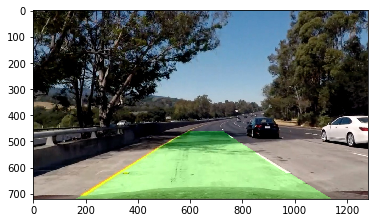

array([[[ 39,  40,  22],
        [ 31,  32,  14],
        [ 24,  25,   8],
        ..., 
        [ 88, 103, 125],
        [ 85, 100, 121],
        [ 83,  97, 117]],

       [[ 46,  47,  29],
        [ 37,  38,  20],
        [ 28,  29,  11],
        ..., 
        [ 84, 101, 125],
        [ 78,  95, 119],
        [ 77,  93, 116]],

       [[ 43,  43,  25],
        [ 37,  38,  20],
        [ 31,  32,  14],
        ..., 
        [ 78,  98, 124],
        [ 74,  93, 119],
        [ 80,  97, 121]],

       ..., 
       [[ 76,  51,  44],
        [ 76,  51,  44],
        [ 77,  52,  45],
        ..., 
        [115,  94,  89],
        [115,  94,  89],
        [114,  93,  88]],

       [[ 79,  54,  47],
        [ 79,  54,  47],
        [ 80,  55,  48],
        ..., 
        [116,  96,  90],
        [117,  97,  91],
        [117,  97,  92]],

       [[ 82,  57,  50],
        [ 82,  57,  50],
        [ 83,  58,  51],
        ..., 
        [117,  97,  92],
        [118,  99,  93],
        [119, 100,

In [20]:
def view_lines(binary_warped, left_fitx, right_fitx, ploty, Minv, img, undist):

    # Create an image to draw the lines on
    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
    plt.imshow(result)
    plt.show()

    return result

view_lines(binary_warped, left_fitx, right_fitx, ploty, Minv, image, undist)

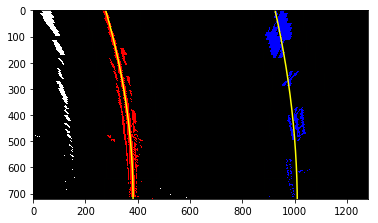

2469.2310659 3335.64072042
720
18687
811.027459751 m 1095.43853428 m


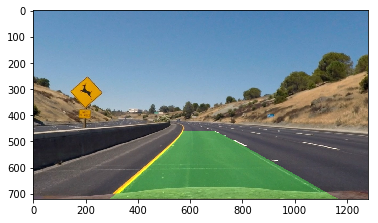

False


array([[[ 96, 145, 188],
        [ 95, 144, 187],
        [ 94, 143, 186],
        ..., 
        [ 78, 130, 180],
        [ 78, 130, 180],
        [ 78, 130, 180]],

       [[ 95, 144, 187],
        [ 94, 143, 186],
        [ 94, 143, 186],
        ..., 
        [ 78, 130, 180],
        [ 78, 130, 180],
        [ 78, 130, 180]],

       [[ 95, 144, 187],
        [ 94, 143, 186],
        [ 93, 142, 185],
        ..., 
        [ 78, 130, 179],
        [ 78, 130, 179],
        [ 78, 130, 178]],

       ..., 
       [[ 97,  83,  96],
        [ 98,  84,  97],
        [ 98,  84,  98],
        ..., 
        [122,  98,  88],
        [121,  97,  87],
        [119,  95,  85]],

       [[ 97,  84,  96],
        [ 98,  85,  97],
        [ 99,  86,  98],
        ..., 
        [121,  97,  87],
        [122,  98,  88],
        [120,  96,  86]],

       [[100,  87,  97],
        [100,  87,  97],
        [101,  88,  98],
        ..., 
        [118,  95,  85],
        [120,  96,  86],
        [119,  95,

In [21]:
# Choose a Sobel kernel size
ksize = 9 # Choose a larger odd number to smooth gradient measurements


def pipeline(img, mtx, dist):
    
    undist = cv2.undistort(img, mtx, dist, None, mtx)

    # Apply each of the thresholding functions
    grady = abs_sobel_thresh(undist, orient='y', sobel_kernel=ksize, thresh=(20, 100))
    dir_binary = dir_threshold(undist, sobel_kernel=ksize, thresh=(0.7, 1.4))
    h_binary = h_threshold(undist, h_thresh=(15,100))
    s_binary = s_threshold(undist, s_thresh=(170,255))

    combined_gradient = np.zeros_like(dir_binary)
    combined_gradient[(grady == 1) & (dir_binary == 1)] = 1

    combined_color = np.zeros_like(dir_binary)
    combined_color[(h_binary == 1) & (s_binary == 1)] = 1

    combined = np.zeros_like(combined_gradient)
    combined[(combined_gradient == 1) | (combined_color == 1)] = 1
    
    binary_warped, Minv = warper(combined, src, dst)
    
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    
    if pipeline.first == True:
        out_img, ploty, left_fit, right_fit, left_fitx, right_fitx, leftx, lefty, rightx, \
        righty = slid_window_fit_poly(binary_warped, histogram)
        
        pipeline.first = False
    else:
        result, ploty, left_fit, right_fit, left_fitx, right_fitx, leftx, lefty, rightx, \
        righty = new_slid_window_fit_poly(binary_warped, left_fit, right_fit)
    
    left_curverad, right_curverad = meas_curvature(ploty, left_fit, right_fit, leftx, lefty, rightx, righty)
    
    result = view_lines(binary_warped, left_fitx, right_fitx, ploty, Minv, img, undist)
    print(pipeline.first)
    return result

img = mpimg.imread('C:/Users/Raul/Documents/CarND-Advanced-Lane-Lines/test_images/test2.jpg')

pipeline.first = True
pipeline(img, mtx, dist)
    
        

## Writeup and Submission

If you're satisfied with your video outputs, it's time to make the report writeup in a pdf or markdown file. Once you have this Ipython notebook ready along with the writeup, it's time to submit for review! Here is a [link](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) to the writeup template file.


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [ ]:
challenge_output = 'test_videos_output/challenge.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip3 = VideoFileClip('test_videos/challenge.mp4').subclip(0,5)
clip3 = VideoFileClip('test_videos/challenge.mp4')
challenge_clip = clip3.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))